# DTU 46500 :  Assignment 1
## Statistical extrapolation for Extreme Winds    (2022)
#### Fitting extreme distributions, uncertainty in fitting (including sample-length)
> python note: A very convenient method to work with tabular data is the dataframes made available by the pandas package. However, in this particular exercise we don't specifically need dataframes as the amount of work on tabular data is limited to the filtering part. 
For simplicity we will wait with introducing the dataframes to a future exercise, and we will work with numpy arrays.

In [1]:
####################################
# Special code for Jupyter Notebook
####################################
# Show plots in the notebook
%matplotlib inline 

# Automatically reload any packages that changed
%load_ext autoreload
%autoreload 2

# Display multiple arguments
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import datetime
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
Data = np.genfromtxt('Hovsore2004to2020_U+dir.csv',delimiter=',')
Dnames = ['Timestamp','Wsp','MeanDir']

In [4]:
# CREATE A DATETIME ARRAY SO WE CAN USE ∆T for removing bad data
T = np.empty(Data[:,0].shape, dtype = datetime.datetime) # Empty numpy array of type datetime
for i in range(len(Data[:,0])):
    T[i] = datetime.datetime.strptime(str(Data[i,0].astype('int64')),'%Y%m%d%H%M')
DeltaT = np.diff(T)

In [5]:
DeltaT

array([datetime.timedelta(seconds=600), datetime.timedelta(seconds=600),
       datetime.timedelta(seconds=600), ...,
       datetime.timedelta(seconds=600), datetime.timedelta(seconds=600),
       datetime.timedelta(seconds=600)], dtype=object)

Insert reasonable values for minimum U to consider, maximum reasonable U (i.e. to avoid instrumental/data errors), and maximum acceptable jump in 10-minute mean windspeed from one record to the next: 

In [6]:
LowestWindSpeed = 0.5 # find something 
CrazyWind = 228/3.6 # highest recorded in europe, alto de orduna
maxDeltaU10min = 10. # maximum change of data between two 10 minute ranges

In [7]:
# CREATE data-selection "masks" (by using Boolean T/F arrays)

WspOK = ((Data[:,1] > LowestWindSpeed)&(Data[:,1] < CrazyWind)) # Boolean (T or F): reject unrealistic wind speeds

DeltaU = np.diff(Data[:,1])
dU10min = np.empty(DeltaU.shape,dtype = 'float')
for i in range(len(DeltaU)):
    dU10min[i] = DeltaU[i]/(DeltaT[i].seconds/600) 
DeltaUOK = (DeltaU > -maxDeltaU10min) & (DeltaU < maxDeltaU10min) 

OK1 = (WspOK[0:-1]==True) & (DeltaUOK == True)
OK2 = (WspOK[1:]==True) & (DeltaUOK == True)
OK1 = np.append(OK1,True)
OK2 = np.insert(OK2,0,True)

DataOK = OK1 & OK2 # Final filter in terms of a Boolean array

In [8]:
# APPLY FILTERS AND COMPUTE YEAR/MONTH VALUES 

T = T[DataOK]
Timestamp = Data[DataOK,0]
Wsp = Data[DataOK,1]
wdir = Data[DataOK,2]

# Compute year and month
Year = np.floor(Timestamp/1e8).astype('int64')
Month = np.floor(np.mod(Timestamp,1e8)/1e6).astype('int64')
#Day = np.floor(np.mod(Timestamp,1e6)/1e4).astype('int64')
#Hour = np.floor(np.mod(Timestamp,1e4)/1e2).astype('int64')
#Minute = np.floor(np.mod(Timestamp,1e2)/1).astype('int64')

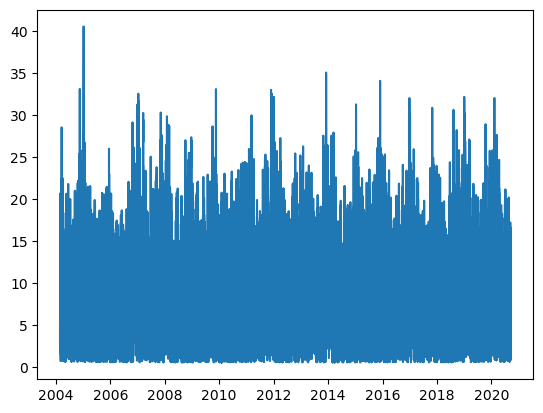

In [9]:
# plot the filtered data to check it:
plt.plot(T,Wsp)
plt.show()

In [10]:
# COMPUTE ANNUAL MAXIMA

Years = np.unique(Year) # yields the unique values of years
nyears = np.max(Years) - np.min(Years) # yields the number n of years

Umax = np.empty(nyears,dtype = 'float') # initialize an empty array
## since data starts in October, make each "year" start then
for i in range(nyears):
    CurrentPeriod = ((Year==Years[i]) & (Month >= 10)) | ((Year == (Years[i]+1)) & (Month < 10))
    Umax[i] = max(Wsp[CurrentPeriod])

# [1a]
### GUMBEL FIT - METHOD OF Probability-weighted moments (PWM)
Use the formulae from class to compute $\alpha$ and $\beta$ from $b_0$ and $b_1$ using PWM. 

Then use $\{\alpha,\beta\}$ to get $V_{50}$. 

You'll do this a number of times; 
- first, based on the whole dataset, 
- then again, using 2-year non-overlapping segments you'll find 7 "two-year" values of $\{\alpha,\beta,V_{50}\}$. 

The framework for code below helps you start out.

You'll also need to **answer quantitatively: "how well does this follow a Gumbel distribution!?" for both cases.**  
Try to quantify the variation of using only 2-year periods; how does this compare to theoretical expectation? 

In [11]:
UmaxSorted = np.sort(Umax) # 1. Sort by U by value
N = len(UmaxSorted)
gamma = 0.577 # euler mascheroni np.euler_gamma

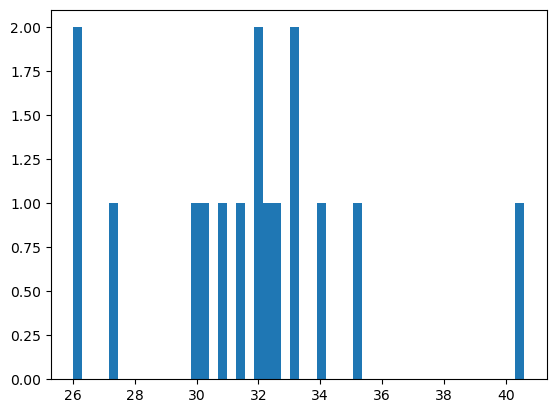

In [12]:
fig1 = plt.figure()
axs1 = plt.gca()
hist1 = axs1.hist(UmaxSorted,50)

In [13]:
b0PWM = (1/N) * np.sum( UmaxSorted ) #calc b0 value first parameter

In [14]:
#b1PWM # 10 to 20 

In [15]:
#----> calculate b1PWM - second parameter
#b1PWM = np.sum( (1/len(UmaxSorted))*(/)*UmaxSorted ) 
b1PWM = 0
for i in range(1,N):
    b1PWM =((i-1) /(N-1) ) * UmaxSorted[i]
b1PWM = (1/N)*b1PWM

In [16]:
b1PWM

2.3680824597676597

In [17]:
index_list = np.arange(0,16)
b1_test = np.sum((1/((N-1)*N) * index_list*UmaxSorted ))
print(b1_test)
b1PWM = b1_test

16.815586121877033


In [18]:
alphaPWM = (2*b1PWM - b0PWM) / np.log(2) # ususally between 1-3

In [19]:
betaPWM = b0PWM - gamma*alphaPWM #10 to 20 ususally

In [20]:
V50PWM = betaPWM + alphaPWM*np.log(50) # yields 50 year 

In [21]:
print('PWM: V50= '+str(V50PWM.round(1))+' m/s; alpha='+str(alphaPWM.round(2))+', beta='+str(betaPWM.round(1))+' m/s')

PWM: V50= 41.0 m/s; alpha=2.8, beta=30.1 m/s


In [22]:
# redo for different dataset lengths
for i in range(nyears):
    CurrentPeriod = ((Year==Years[i]) & (Month >= 10)) | ((Year == (Years[i]+1)) & (Month < 10))
    Umax[i] = max(Wsp[CurrentPeriod])
    
N_lengths
U_data_var_length = [ for i in np.linspace(0,,N_lengths)]# list of datasets with variable lengths 
for U_list in []
    UmaxSorted = np.sort(Umax)
    b0PWM = np.sum( (1/len(UmaxSorted))*UmaxSorted ) 
    #b1PWM = np.sum( (1/len(UmaxSorted))*(/)*UmaxSorted ) 
    b1PWM = 0
    N = len(UmaxSorted)
    gamma = 0.577
    for i in range(N):
        b1PWM = (1/N) * ((i-1) /(N-1) ) * UmaxSorted[i]
    alphaPWM = (2*b1PWM - b0PWM) / np.log(2)
    betaPWM = b0PWM - gamma*alphaPWM
    V50PWM = betaPWM + alphaPWM*np.log(50) # yields 50 year 
#print('PWM: V50= '+str(V50PWM.round(1))+' m/s; alpha='+str(alphaPWM.round(2))+', beta='+str(betaPWM.round(1))+' m/s')

SyntaxError: invalid syntax (200304841.py, line 7)

### GUMBEL FIT - V50 from another method
Now use another method (of your choice) to calculate $V_{50}$ (e.g. max-likelihood, ACER, etc.). <br>
How well does this fit the Gumbel PDF (or CDF)?

 - Max likelihood method chosen

In [68]:
# likelihood function for gumbell distribution
from scipy import optimize, stats
Wsp_sorted = np.sort(Wsp)

#Gumbel 
gumbel_likelihood = lambda theta :-np.sum( np.log( sp.stats.gumbel_r.pdf(Wsp_sorted,loc=theta[0],scale=theta[1]) ) ) # Definition of the negative log-likelihood function; Wsp is the windspeed
gumbel_optimum = optimize.minimize(gumbel_likelihood,[10,3.7]) # Minimization to find the optimal distribut=30.1 m/s

# Gumbel likelihood for umaxsorted
gumbel_likelihood_max = lambda theta :-np.sum( np.log( abs(sp.stats.gumbel_r.pdf(UmaxSorted,loc=theta[0],scale=theta[1]) ) )) # Definition of the negative log-likelihood function; Wsp is the windspeed
gumbel_optimum_max = optimize.minimize(gumbel_likelihood_max,[30,3]) # Minimization to find the optimal distribut=30.1 m/s


#Weibull
weibull_likelihood = lambda theta: -np.sum(np.log(sp.stats.weibull_min.pdf(UmaxSorted,c=theta[0],scale=theta[1])))
weibull_optimum = optimize.minimize(weibull_likelihood,[1,1])

#ion parameters
# What is U ? 
#now the optimum is for the parameters scale 0 theta1 and loc theta 0 are calculated 

#gumbel plot as (i/N+1)

gumbel_likelihood2 = lambda theta: -np.sum(np.log(stats.gumbel_r.pdf(Wsp_sorted,scale = theta[1], loc = theta[0]))) # Definition of the gumbel function
gumbel_opt2 = sp.optimize.minimize(gumbel_likelihood,[10,5]) # Minimization to find the optimal distribution parameters

#Frechet
def frechet_cdf(x,alpha,scale,loc=0): 
    p = np.exp(-((x-loc)/scale)**(-alpha))
    return p
def frechet_pdf(x,alpha,scale,loc=0): #implementation like this does not really work
    p = (alpha/scale) * ((x-loc)/scale)**(-1-alpha)
    return p 
frechet_likelihood = lambda theta: -np.sum(np.log(frechet_pdf(Wsp_sorted,theta[0],theta[1]))) # Definition of the frechet mle function
frechet_opt = sp.optimize.minimize(frechet_likelihood,[10,5]) # Minimization to find the optimal distribution parameters


/tmp/ipykernel_2802/3139498380.py:32: RuntimeWarning: overflow encountered in power
  p = (alpha/scale) * ((x-loc)/scale)**(-1-alpha)
/home/mi/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_2802/3139498380.py:32: RuntimeWarning: overflow encountered in power
  p = (alpha/scale) * ((x-loc)/scale)**(-1-alpha)
/tmp/ipykernel_2802/3139498380.py:32: RuntimeWarning: overflow encountered in multiply
  p = (alpha/scale) * ((x-loc)/scale)**(-1-alpha)
/home/mi/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [27]:
display(gumbel_optimum_max.x)
display(weibull_optimum.x)

array([30.04518147,  3.09108612])

array([ 8.88531354, 33.26638446])

Text(0.5, 0, '1 year max ranked')

Text(0, 0.5, 'pdf fit')

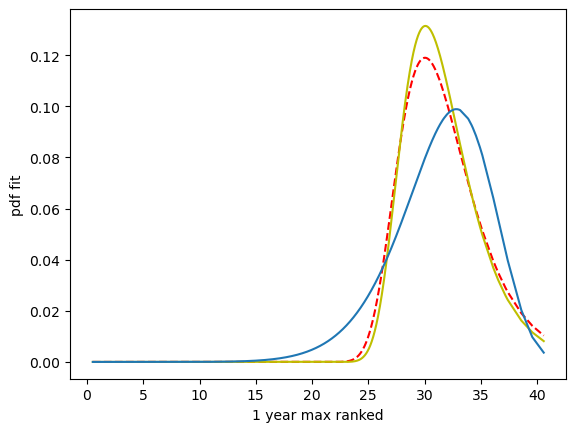

In [29]:
# Compare to data ! 
if False:
    fig1 = plt.figure()
    axs1 = plt.gca()
    hist1 = axs1.hist(Wsp,50)
    plt.xlabel('Mean wind speed [m/s]')
    plt.ylabel('Number of occurrences')
    plt.title('Histogram of 10-minute mean wind speed at Høvsøre')
    plt.show()


Wsp_sorted = np.sort(Wsp)


#plt.plot(Wsp_sorted,stats.gumbel_r.pdf(Wsp_sorted,loc = gumbel_optimum.x[0],scale = gumbel_optimum.x[1]),'--r')
plt.plot(Wsp_sorted,stats.gumbel_r.pdf(Wsp_sorted,loc = gumbel_optimum_max.x[0],scale = gumbel_optimum_max.x[1]),'--r')
#plt.plot(Wsp_sorted,stats.gumbel_r.pdf(Wsp_sorted, scale=gumbel_opt2.x[1],loc = gumbel_opt2.x[0]),'--r')
plt.plot(Wsp_sorted,stats.gumbel_r.pdf(Wsp_sorted,loc = betaPWM, scale=alphaPWM ),color="y")
plt.plot(Wsp_sorted,stats.weibull_min.pdf(Wsp_sorted,weibull_optimum.x[0],scale=weibull_optimum.x[1]))
plt.xlabel("1 year max ranked")
plt.ylabel("pdf fit")

In [44]:
print(f" Beta: PWM:{betaPWM} \t Gumbel: {gumbel_optimum_max.x[0]}")
print(f" Beta: PWM:{alphaPWM} \t Gumbel: {gumbel_optimum_max.x[1]}")
#print(f" Beta: PWM:{alphaPWM} \t Gumbel: {gumbel_optimum_max.x[1]}")
print(weibull_optimum.x)
V50_mle = gumbel_optimum_max.x[0] + gumbel_optimum_max.x[1]*np.log(50) # yields 50 year 
#get v50 from 2% approximation
V50_weibull_mle = stats.weibull_min.ppf(.98,weibull_optimum.x[0],scale=weibull_optimum.x[1] )
V50_gumbelPWM_2 = stats.gumbel_r.ppf(.98,loc = betaPWM, scale=alphaPWM)
# do the thumb rule
V50_thumb = 5* np.mean(Wsp)

 Beta: PWM:30.077226454975012 	 Gumbel: 30.04518146786341
 Beta: PWM:2.798058243307122 	 Gumbel: 3.0910861220777983
[ 8.88531354 33.26638446]


In [45]:
print(V50_mle)

42.13758148919143


In [47]:
# get the 50 year max by the 2% approximation 

print(f'V50 for Gumbel with PWM: {V50PWM}')
print(f'V50 for Gumbel with MLE: {V50_mle}')
print(f'V50 for Weibull with MLE: {V50_weibull_mle}')
print(f'V50 for Gumbel with MLE and 2% rule: {V50_gumbelPWM_2}')
print(f'V50 for thumb rule :  {V50_thumb}')
#print(stats.gumbel_r.ppf(.98,loc = betaPWM, scale=alphaPWM))

#print(stats.gumbel_r.ppf(.98,loc = gumbel_optimum_max.x[0], scale=gumbel_optimum_max.x[1]))


V50 for Gumbel with PWM: 41.023294673320336
V50 for Gumbel with MLE: 42.13758148919143
V50 for Weibull with MLE: 38.78623077226182
V50 for Gumbel with MLE and 2% rule: 40.9950780816911
V50 for thumb rule :  46.10867496455005


Text(0.5, 1.0, 'V50 values for different Methods')

Text(0.5, 0, 'V50 [m/s]')

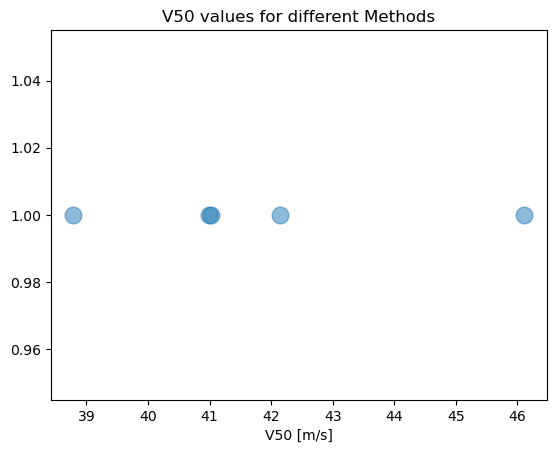

In [64]:
V50_list = [V50PWM,V50_mle,V50_weibull_mle,V50_gumbelPWM_2,V50_thumb]
plt.plot(V50_list, [1]*len(V50_list),'o',markersize=12,alpha=.5)
plt.title("V50 values for different Methods")
plt.xlabel("V50 [m/s]")

In [86]:
print(gumbel_opt2.x)
print(gumbel_optimum_max.x)

[7.12936244 3.74642124]
[30.04518147  3.09108612]


In [89]:
betaPWM

30.077226454975012

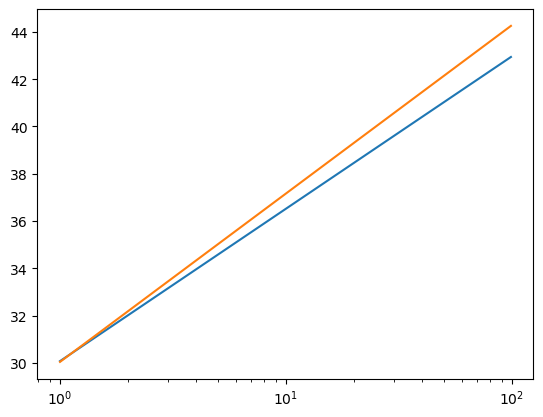

In [91]:
#plt.plot(UmaxSorted)
#plt.plot(Wsp_sorted,stats.gumbel_r.pdf(Wsp_sorted,loc = gumbel_optimum_max.x[0],scale = gumbel_optimum_max.x[1]),'--r')
uT = lambda T: betaPWM +  alphaPWM * np.log(T/1)
uT_mle = lambda T: gumbel_optimum_max.x[0] +  gumbel_optimum_max.x[1] * np.log(T/1)
x = np.arange(1,100)
plt.semilogx(x, [uT(xi) for xi in x])
plt.semilogx(x, [uT_mle(xi) for xi in x])

In [108]:
# try ks test 
# result does not make sense - not for normal dist. either
sp.stats.kstest(UmaxSorted, 'gumbel_r') # ,args=(alphaPWM))

KstestResult(statistic=0.9999999999949549, pvalue=3.5230002200630353e-181)

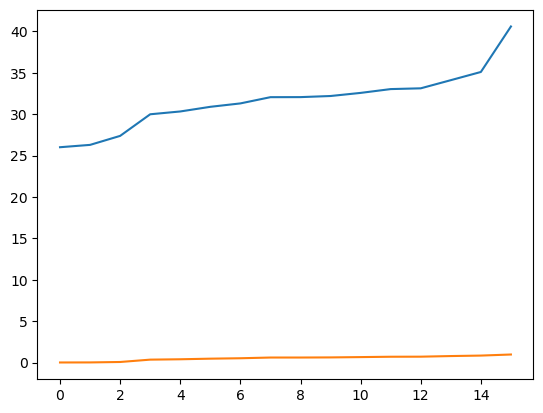

In [121]:
# make the log plot for U_ranked 
A = np.trapz(UmaxSorted)
B = np.trapz(UmaxSorted)
plt.plot(UmaxSorted)
plt.plot(sp.stats.gumbel_r.cdf(UmaxSorted,betaPWM,scale=alphaPWM))

In [119]:
A

473.763147354126

### To dp
- comparison of values 
 - IEC turb - makes a difference ? 
 - plot of different results 
 - 42.5 limit 

# 1b: Uncertainty in $V_{50}$ estimates
Using the $\alpha$-parameter you found above in [1a] using _the whole 16-year timeseries_, 
- do bootstrap sampling with many 2-year segments to get a distribution of $f_{2y}(\alpha$ and $f_{2y}(V_{50})$; 
     - what is the uncertainty in using 2-year segments, i.e., the standard deviation $\sigma_{V50_\textrm{fit 2yr}}$
- repeat this for other segment lengths (3 years, 4y...10y), to get (fit) a relation for $\sigma^2_{V50}(T_\textrm{segment})$
- How does your relation for $\sigma^2_{V50}(T_\textrm{segment})$ compare to the Ott(2011) expression for $\sigma^2_{U_T}$? 
    - ignoring $\beta$, how much variation in $\alpha$ (e.g. $\sigma_\alpha/\langle\alpha\rangle$) does your $\sigma^2_{V50}(T_\textrm{segment})$ correspond to? 

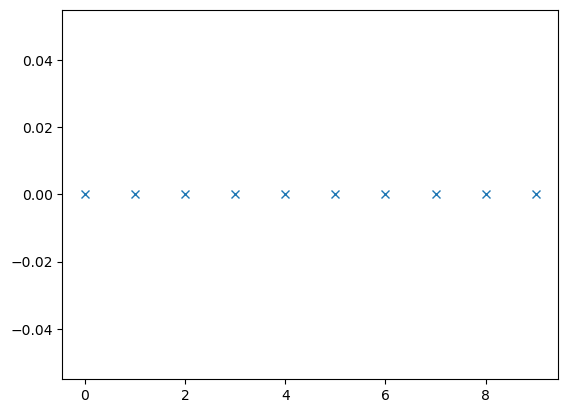

In [51]:
import numpy as np
import matplotlib.pyplot as pp
val = 0. # this is the value where you want the data to appear on the y-axis.
ar = np.arange(10) # just as an example array
pp.plot(ar, np.zeros_like(ar) + val, 'x')
pp.show()
